In [ ]:
!pip install PyDrive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install gensim
!pip install -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 6.4 MB/s 
     |████████████████████████████████| 1.6 MB 42.5 MB/s 


In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Autorizar el acceso a tu propia cuenta de google drive, 
# siga el enlace, acepte y copie el codigo de verificación.

In [ ]:
# Model Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SimpleRNN, LSTM, GRU, Dropout
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from gensim.models.keyedvectors import KeyedVectors
import tensorflow as tf
from sklearn.model_selection import train_test_split
import nltk
from os import getcwd
import gensim
from gensim.test.utils import common_texts

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# File Extraction
myfile = drive.CreateFile({'id': '1lplFks3KhziL00KzyRKYnh9WNmvhLO0-'})
myfile.GetContentFile('BIAS_TWEETS_f.csv')

In [ ]:
# Reading File
df = pd.read_csv('BIAS_TWEETS_f.csv', encoding = 'utf8')
df.head()

,full_text,polarity
0,"tienes al fifas dedicándote los goles, qué más...",0
1,"Por amor a Cristo, pq me gustaron tantos fifas...",1
2,"Fui la fifas de la relación hoy, tan así que l...",0
3,@marianesquivel_ @SantVent @2010MisterChip Act...,0
4,"Podré ser un FIFAs, pero jamás me verán gritan...",1


In [ ]:
import re
import string
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer


def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('spanish')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean


def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
X_raw=np.array(df.full_text)
y=np.array(df.polarity)

print(X_raw.shape)
print(y.shape)

print(X_raw[0])
print(process_tweet(X_raw[0]))

(1217,)
(1217,)
tienes al fifas dedicándote los goles, qué más quieres?
['fifa', 'dedicándot', 'gole', 'quier']


In [ ]:
preprocess_list = np.array([process_tweet(x) for x in X_raw])
print(preprocess_list.shape)

(1217,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
# Word to vector
maxlen = 100 #max number of word
max_words = 20000 #considers the first 20000 words

tokenizer = Tokenizer(num_words=max_words, lower = False)
tokenizer.fit_on_texts(preprocess_list)
sequences = tokenizer.texts_to_sequences(preprocess_list)

In [ ]:
import pickle

with open('tokenizer_bbva3.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Word idctionary
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)

Found 4671 unique tokens.


In [ ]:
# Label Vector
sent_dic = dict(zip(df.polarity.unique(), range(len(df.polarity.unique()))))
df["Sent_Code"] = [sent_dic[x] for x in df.polarity]
Y = keras.utils.to_categorical(df.Sent_Code)

In [ ]:
# Shape of data
labels = np.asarray(Y)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (1217, 100)
Shape of label tensor: (1217, 2)


In [ ]:
# Data Shuffle
indices = np.arange(data.shape[0])
np.random.seed(170298)
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Dataset Split
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size = .3)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size = .5)

In [ ]:
print(x_train.shape)
print(x_val.shape)

(851, 100)
(183, 100)


In [ ]:
# Import Embedding
myfile = drive.CreateFile({'id': '1TJ5XroELn2aMQKgvSCajA5juqKqQ7Zam'})
myfile.GetContentFile('sbw_vectors.bin')


#model_wv = gensim.models.Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
embedd = KeyedVectors.load_word2vec_format("sbw_vectors.bin", binary=True)
# embedd_2 = gensim.models.Word2Vec.load(embedd)
# embedd.

In [ ]:
model = Sequential()
model.add(embedd.get_keras_embedding(train_embeddings = False))
#model.add(model_wv.wv.get_keras_embedding(train_embeddings=False))
model.add(GRU(32, dropout = 0.2, recurrent_dropout = 0.3, return_sequences = True))
model.add(LSTM(32, return_sequences = True))
model.add(GRU(16))
model.add(Dense(8, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(2, activation='softmax'))
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         300195900 
                                                                 
 gru (GRU)                   (None, None, 32)          32064     
                                                                 
 lstm (LSTM)                 (None, None, 32)          8320      
                                                                 
 gru_1 (GRU)                 (None, 16)                2400      
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1

In [ ]:
# Compilation

from keras.callbacks import ModelCheckpoint
from keras import optimizers

batch=200

#model.compile(optimizer=optimizers.Adam(lr=.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=.001), metrics=['acc']) 

checkpointer = ModelCheckpoint(filepath= "Modelo_Ian_7.h5", monitor='val_acc', verbose=0, 
                               save_best_only=True, mode='max', period=1)

history = model.fit(x_train, y_train, epochs=25, batch_size=batch, steps_per_epoch=x_train.shape[0]//batch, validation_data=(x_val, y_val), 
                    callbacks=[checkpointer])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/25
4/4 [==============================] - 19s 3s/step - loss: 0.6264 - acc: 0.7175 - val_loss: 0.6008 - val_acc: 0.7104
Epoch 2/25
4/4 [==============================] - 1s 359ms/step - loss: 0.6153 - acc: 0.7220 - val_loss: 0.6072 - val_acc: 0.7104
Epoch 3/25
4/4 [==============================] - 1s 321ms/step - loss: 0.5730 - acc: 0.7419 - val_loss: 0.5995 - val_acc: 0.7104
Epoch 4/25
4/4 [==============================] - 1s 341ms/step - loss: 0.5859 - acc: 0.7281 - val_loss: 0.5959 - val_acc: 0.7104
Epoch 5/25
4/4 [==============================] - 1s 346ms/step - loss: 0.5975 - acc: 0.7127 - val_loss: 0.5947 - val_acc: 0.7104
Epoch 6/25
4/4 [==============================] - 1s 332ms/step - loss: 0.5895 - acc: 0.7237 - val_loss: 0.5937 - val_acc: 0.7104
Epoch 7/25
4/4 [==============================] - 1s 347ms/step - loss: 0.5748 - acc: 0.7358 - val_loss: 0.5936 - val_acc: 0.7104
Epoch 8/25
4/4 [==============================] - 1s 332ms/step - loss: 0.5991 - acc: 0.7127

In [ ]:
!mkdir -p saved_model
model.save('saved_model/model_light_Hackathon.h5') 

In [ ]:
model.evaluate(x_train, y_train)

27/27 [==============================] - 1s 32ms/step - loss: 0.4212 - acc: 0.7262


[0.4211597144603729, 0.7262044548988342]

6/6 [==============================] - 1s 30ms/step
0.7704918032786885


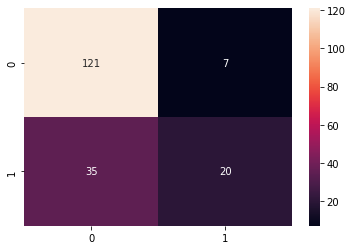

In [ ]:

# Prediction and confussion matrix
#predic = model.predict_classes(x_test)
predic = (model.predict(x_test)[:,1] >= 0.43)
true = [np.argmax(x) for x in y_test]

cm = confusion_matrix(true, predic)
heatmap(cm, annot = True, fmt = 'd')
resultado = (cm[0][0] + cm[1][1]) / y_test.shape[0]
print(resultado)

In [ ]:
x_train

array([[   0,    0,    0, ..., 2530,  205,    1],
       [   0,    0,    0, ..., 1871,  502,    1],
       [   0,    0,    0, ..., 4291,  958, 4292],
       ...,
       [   0,    0,    0, ..., 1749,   22,  483],
       [   0,    0,    0, ..., 3962, 1559, 3963],
       [   0,    0,    0, ..., 4628, 4629,  567]], dtype=int32)

In [ ]:
import sklearn
from sklearn.metrics import classification_report
import xgboost as xgb

model = xgb.XGBClassifier(n_estimators = 50, max_depth = 6, learning_rate = 0.05)
model.fit(x_train, y_train[:,1])

XGBClassifier(learning_rate=0.05, max_depth=6, n_estimators=50)

In [ ]:
print(classification_report(model.predict(x_train), y_train[:,1]))

              precision    recall  f1-score   support

         0.0       0.98      0.86      0.92       707
         1.0       0.58      0.93      0.71       144

    accuracy                           0.87       851
   macro avg       0.78      0.90      0.81       851
weighted avg       0.91      0.87      0.88       851



In [ ]:
print(classification_report(model.predict(x_test), y_test[:,1]))

              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89       152
         1.0       0.49      0.87      0.63        31

    accuracy                           0.83       183
   macro avg       0.73      0.84      0.76       183
weighted avg       0.89      0.83      0.84       183



In [ ]:
# Save as JSON file
#model.save_model("saved_model/xg_model_Hackathon.json")
# Save as TXT file
!mkdir -p saved_model
model.save_model("saved_model/xg_model_Hackathon.txt") 

In [ ]:
import tensorflow as tf
import kerastuner as kt
print(tf.__version__)
print(kt.__version__)

2.3.0
1.0.1


In [ ]:
from kerastuner import HyperModel

class RegressionHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    def build(self, hp):
        model_h = Sequential()
        print('hola ian')
        model_h.add(
            
            layers.hypermodel

        )
        print('hola ian 2')
        model_h.add(
            layers.GRU(
                units=hp.Int('units', 8, 64, 128, default=8),
                dropout =hp.Float(0.1,.02,0.05) ,
                recurrent_dropout = hp.Float( 0.1, 0.2, 0.3),      
                return_sequences=True
            )
        )
        
        model_h.add(
            layers.LSTM(
                units=hp.Int('units', 16, 64, 128, default=16),
                return_sequences=True
            )
        )

        model_h.add(
            layers.GRU(
                units=hp.Int('units', 16, 64, 128, default=16)
            )
        )

        model_h.add(
            layers.Dense(
                units=hp.Int('units', 16, 64, 32, default=16),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
            )
        )

        
        
        model_h.add(
            layers.Dropout(
                hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.2,
                    default=0.005,
                    step=0.01)
            )
        )

        model_h.add(
            layers.Dense(
                units=hp.Int('units', default=2),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'softmax', 'sigmoid'],
                    default='softmax'),
            )
        )
        
        
        model_h.compile(
            optimizer='adam',loss='binary_crossentropy',metrics=['acc']
        )
        
        return model_h

In [ ]:
input_shape = embedd.get_keras_embedding(train_embeddings = False, word_index = word_index)
hypermodel = RegressionHyperModel(embedd.get_keras_embedding(train_embeddings = False, word_index = word_index))

In [ ]:
tuner_bo = kt.tuners.RandomSearch(
            hypermodel,
            objective='acc',
            seed=42,
            max_trials=10,      
            executions_per_trial=2
        )

hola ian


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-86-dfbc54b2204c>", line 11, in build
    layers.hypermodel
NameError: name 'layers' is not defined


hola ian


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-86-dfbc54b2204c>", line 11, in build
    layers.hypermodel
NameError: name 'layers' is not defined


hola ian


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-86-dfbc54b2204c>", line 11, in build
    layers.hypermodel
NameError: name 'layers' is not defined


hola ian


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-86-dfbc54b2204c>", line 11, in build
    layers.hypermodel
NameError: name 'layers' is not defined


hola ian


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-86-dfbc54b2204c>", line 11, in build
    layers.hypermodel
NameError: name 'layers' is not defined


hola ian


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-86-dfbc54b2204c>", line 11, in build
    layers.hypermodel
NameError: name 'layers' is not defined


RuntimeError: ignored

In [ ]:

tuner_bo.search(x_train, y_train, epochs=10, validation_split=0.2, verbose=0)
best_model = tuner_bo.get_best_models(num_models=1)[0]
best_model.evaluate(x_test_scaled, y_test)